In [24]:
import sys, os
sys.path.insert(1, '../mindeye/src/')

from diffusers import T2IAdapter,  EulerDiscreteScheduler, AutoencoderKL, MultiAdapter, StableDiffusionAdapterPipeline
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms 
from torchvision.utils import make_grid

# import utils 
from models import Clipper, BrainNetwork, BrainDiffusionPriorOld 

import clip 
from clip_client import ClipClient, Modality
import urllib
import io

In [38]:
subj = 1
#for vdvae depth initial image
vdvae_num_layers = 47

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
gt_stim_test = np.load('../data/processed_data/subj{:02d}/nsd_test_stim_sub1.npy'.format(subj,subj)).astype(np.uint8)
caps_test = np.load('../data/processed_data/subj{:02d}/nsd_test_cap_sub{}.npy'.format(subj,subj))
fmri_test = np.load('../data/processed_data/subj{:02d}/nsd_test_fmriavg_nsdgeneral_sub{}.npy'.format(subj,subj))
pred_cliptext = np.load('../data/predicted_features/subj{:02d}/nsd_compel_cliptext_predtest_nsdgeneral.npy'.format(subj))
pred_cliptext = torch.from_numpy(pred_cliptext)

### load BrainNetwork (voxel2clip) and Diffusion Prior

In [17]:
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


In [21]:
# CLS model
out_dim = 768
clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=False, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

diffusion_prior = BrainDiffusionPriorOld.from_pretrained(
    # kwargs for DiffusionPriorNetwork
    dict(),
    # kwargs for DiffusionNetwork
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
    voxel2clip_path=None,
    ckpt_dir='../mindeye/checkpoints',
)

model_name = "prior_1x768_final_subj01_bimixco_softclip_byol"
outdir = f'../mindeye/train_logs/{model_name}/'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]

ViT-L/14 cuda
ckpt_path ../mindeye/train_logs/prior_1x768_final_subj01_bimixco_softclip_byol/last.pth
EPOCH:  299


### function to get CLIP embeddings from fMRI

In [28]:
def get_clip_embeddings(voxels, diffusion_prior, recons_per_sample=1, seed=0):
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)
    brain_clip_embeddings0, proj_embeddings = diffusion_prior.voxel2clip(voxels.to(device).float())
    # brain_clip_embeddings0 = brain_clip_embeddings0.view(len(voxels),-1,768)
    brain_clip_embeddings0 = brain_clip_embeddings0.view(-1,768)
    brain_clip_embeddings0 = brain_clip_embeddings0.repeat(recons_per_sample, 1)
    brain_clip_embeddings = diffusion_prior.p_sample_loop(brain_clip_embeddings0.shape,
                            text_cond = dict(text_embed = brain_clip_embeddings0),
                            cond_scale = 1., timesteps = 1000, #1000 timesteps used from nousr pretraining
                            generator=generator)
    brain_clip_embeddings = brain_clip_embeddings.unsqueeze(1) #(1,1,768)

    return brain_clip_embeddings 

### load CLIP Client and ClIP retrieval functions

In [29]:
model, preprocess = clip.load("ViT-L/14", device="cpu", jit=False)

client = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-L-14",
    aesthetic_score=9,
    aesthetic_weight=0.5,
    modality=Modality.IMAGE,
    num_images=10,
)

In [30]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    display(Image(url=url, unconfined=True))

def download_image(url):
    urllib_request = urllib.request.Request(
        url,
        data=None,
        headers={"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:72.0) Gecko/20100101 Firefox/72.0"},
    )
    with urllib.request.urlopen(urllib_request, timeout=10) as r:
        img_stream = io.BytesIO(r.read())
    return img_stream

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def get_text_emb(text):
    with torch.no_grad():
        text_emb = model.encode_text(clip.tokenize([text], truncate=True).to("cpu"))
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu().detach().numpy().astype("float32")[0]
    return text_emb


def get_image_emb(image_url):
    with torch.no_grad():
        image = Image.open(download_image(image_url))
        image_emb = model.encode_image(preprocess(image).unsqueeze(0).to("cpu"))
        image_emb /= image_emb.norm(dim=-1, keepdim=True)
        image_emb = image_emb.cpu().detach().numpy().astype("float32")[0]
        return image_emb

### load Stable Diffusion with T2I Adapters

In [32]:
adapters = MultiAdapter(
    [
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16),
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_depth_sd14v1", torch_dtype=torch.float16),
    ]
)

model_id = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16)
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapters, scheduler=scheduler, torch_dtype=torch.float16, variant="fp16"
).to(device)

unet\diffusion_pytorch_model.fp16.safetensors not found
Loading pipeline components...:  14%|█▍        | 1/7 [00:01<00:08,  1.37s/it]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


### Reconstruction

In [33]:
def get_color_pallete(img):
    img = img.resize((8,8))
    color_pallete = img.resize((512, 512), resample=Image.Resampling.NEAREST)

    return color_pallete

In [34]:
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
generator = torch.manual_seed(777) 

In [39]:
for ndx, voxels in enumerate(torch.from_numpy(fmri_test)):
    print(ndx)

    clip_embs = get_clip_embeddings(voxels.unsqueeze(0), diffusion_prior)
    query_res = client.query(embedding_input=clip_embs[0][0].tolist())
    caps = query_res[0]["caption"]

    print("ground truth captions: ", list(caps_test[caps_test!='']))
    print("predicted captions: ", caps)
    print("retrieved embs similarity: ", query_res[0]["similarity"])

    color_pallete = get_color_pallete(Image.open('../results/lvae/subj01/stim/{}.png'.format(ndx)))
    depth_img = Image.open('../results/vdvae/subj01/depth_stim_{}l/{}.png'.format(vdvae_num_layers,ndx))

    gen_images = pipe(
    prompt = caps,
    negative_prompt=negative_prompt,
    image=[color_pallete, depth_img],
    adapter_conditioning_scale=[0.9, 0.8],
    num_inference_steps=50,
    guidance_scale=5.5,  
    generator=generator,
    num_images_per_prompt=3,
    ).images

    break

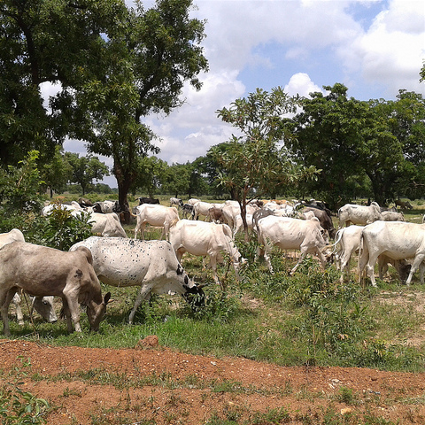

In [40]:
Image.fromarray(gt_stim_test[ndx])

In [ ]:
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 

In [ ]:
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=3)
grid = transforms.ToPILImage()(grid)
grid

In [36]:
voxels.shape

torch.Size([15724])